## 1. Import package:

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from lgbmvisualizer.viz import LGBMVisualizer

## 2. Downloading data from Kaggle competition: House Prices - Advanced Regression Techniques

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv

NOTE: First install kaggle api using below command to get the data. Also ensure you get a API token file from your kaggle account & place it in C:/Users/Username/.kaggle folder . You need this to use the kaggle package to get competition data directly :


In [ ]:
%%capture
!pip install kaggle


In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques -p data

import os
from zipfile import ZipFile

##Extracting the zip file
filename=os.listdir("data/")[0]
with ZipFile("data/"+filename, 'r') as zip:
    zip.printdir()
    zip.extractall("data/")


## 3. Import data:

In [2]:
import pandas as pd

df=pd.read_csv("data/train.csv")
df.head()



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Lets have a look at the datatypes
print(df.dtypes.value_counts())
print("###########\n")
print(df.shape)

object     43
int64      35
float64     3
dtype: int64
###########

(1460, 81)


We are creating a uniformly distributed weight column just to showcase. The package works even without specifying a weight column

In [4]:
target_column = "SalePrice"


import numpy as np
df["weight"] = np.random.uniform(low=0.9, high=1.1, size=len(df))
weight_column = "weight"

## 4. Using LGBMVisualizer() to plot SHAP Interaction Values:

* `LGBMVisualizer` essentially fits a [LightGBM](https://lightgbm.readthedocs.io/en/latest/) model to get the SHAP interaction values. If you have already done hyperparameter tuning for your model, you can pass the parameters to reduce the runtime. Else the package would use default hyperparameter values & slightly tune the number of trees. 

We pass the below hyperparameters that we had tuned separately:

In [5]:
params = {'learning_rate': 0.04, 
          'max_depth': 8, 
          'num_leaves': 999, 
          'reg_lambda': 7.590589358300042, 
          'bagging_fraction': 0.6200762468698007, 
          'bagging_freq': 1, 
          'reg_alpha': 20.684874282108627, 
          'min_gain_to_split': 7.6153442293342675, 
          'cat_l2': 20.31189949433954, 
          'feature_fraction': 0.4, 
          'max_cat_threshold': 48, 
          'cat_smooth': 3.7565474645348047, 
          'verbosity': -1, 
          'objective': 'rmse'
         }

In this first section we set `twofold_shap` to False to show you its usage.
###  4.1. When to set `twofold_shap=False`?:
* Set it to False when your data is large (high rows or columns) since running SHAP on large datasets is a very timeconsuming process.
* Even when you have large datasets, you can still set `twofold_shap to False` but you have to use the `pc_data_for_interaction_detection` argument which essentially uses only a user-specified percent of your dataset for shap calculations, hence reducing the runtime

Below demonstrates the time difference between pct_reduce_after_model=0.5 and pct_reduce_after_model=0.0 

In [6]:
%%time
lgbm_viz = LGBMVisualizer(params=params, data=df, target_column=target_column, weight_column=weight_column, n_trees=200,
                      twofold_shap=False, pc_data_for_interaction_detection=0.5)

CPU times: total: 25.4 s
Wall time: 20.1 s


In [7]:
%%time
lgbm_viz = LGBMVisualizer(params=params, data=df, target_column=target_column, weight_column=weight_column, n_trees=200,
                      twofold_shap=False, pc_data_for_interaction_detection=0.0)

CPU times: total: 35.9 s
Wall time: 31 s


* As you can see from the runtime above, reducing the dataset size by half also reduces the runtime by almost half since majority of the runtime is dependent on shap calculations.

### 4.2. `LGBMVisualizer.find_interactions()`: Function to plot 2-way interactions:

#### 4.2.1 Interaction plot between 2 variables:
Lets plot the interaction values for a pair(tuple) of variables specified by the user.

Here we use the 2 most important variables in the model : "OverallQual" & "GrLivArea" 

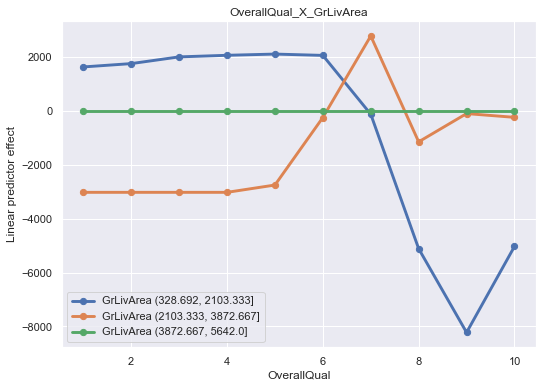

In [8]:
lgbm_viz.find_interactions(variables=("OverallQual", "GrLivArea"))

#### 4.2.2 To find most impactful interactions with a particular variable:

Now lets say we want to know which variables a particular feature interacts with the most. The `find_interactions()` function can also help you with this. Below we look at the top 5 interactions with variable `OverallQual`:

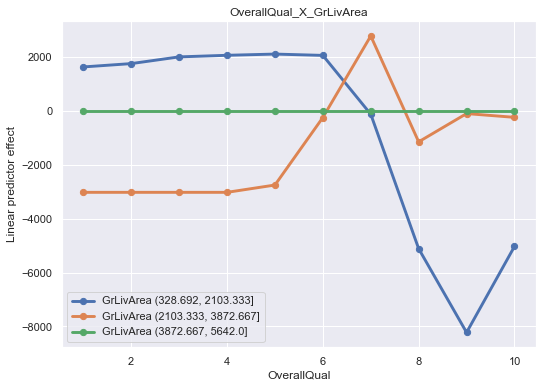

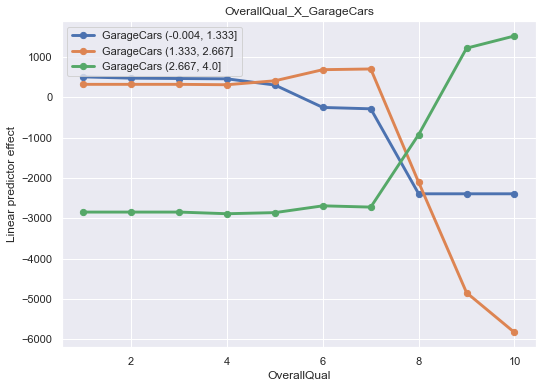

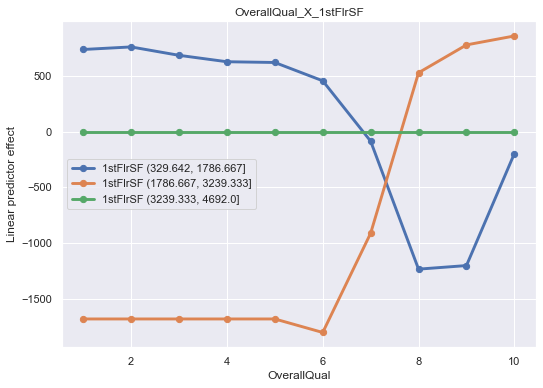

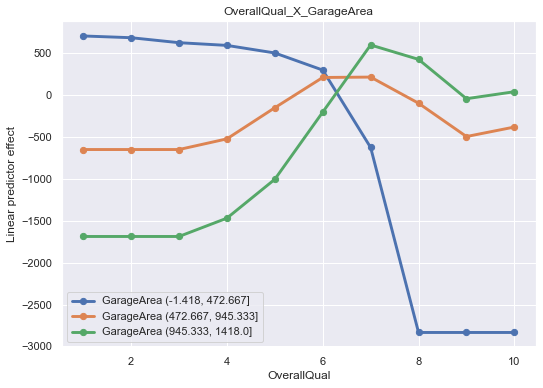

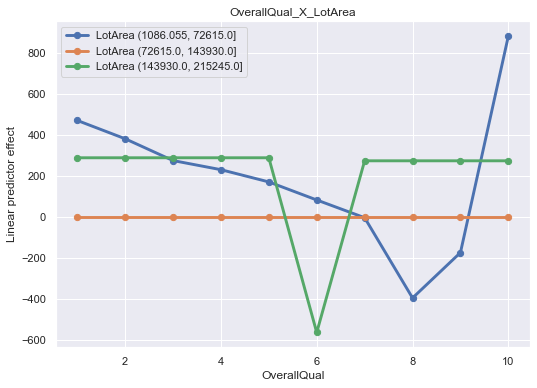

In [9]:
lgbm_viz.find_interactions("OverallQual", total_interactions_per_var=5)

The second interaction plot above with the `GarageCars` variable has only 3 bins, but the variable itself has 5 levels(0,1,2,3,4). We can increase or decrease the bin size as we like using the `total_bins_for_num_cols` argument. Lets set it to 5

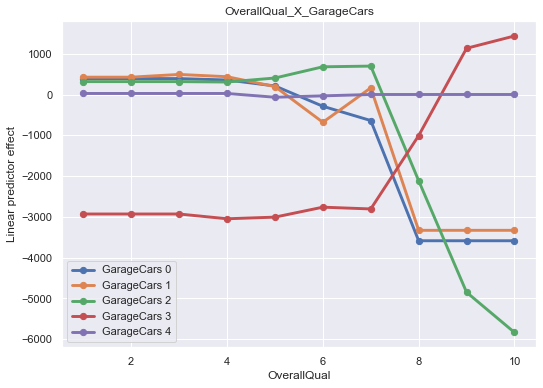

In [10]:
lgbm_viz.find_interactions(("OverallQual", "GarageCars"), total_bins_for_num_cols=5)

#### 4.2.3 How are missing values handled?

The package automatically handles missing values as a separate cateogory if its a categorical variable or it assigns -1 by default if its a numeric. Since the default value of -1 isnt suited for all numeric variables, you can set your own missing value replacement value using the `impute_missing_with` argument.

Lets look at the variable `GarageYrBlt` variable which has missing values & how the package handles it:

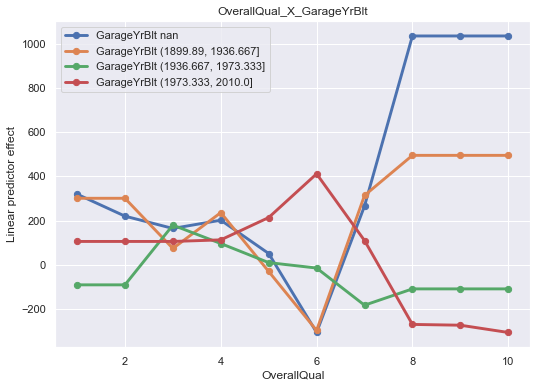

In [11]:
lgbm_viz.find_interactions(("OverallQual", "GarageYrBlt"), total_bins_for_num_cols=3)

* In the above interaction plot we specified the `total_bins_for_num_cols` to 2 bins, but we got 3. The 3rd one here is the interaction values for the missing value cases & the package is designed to isolate missing values so that the user gets a more refined look without having to made changes themselves.


#### 4.2.4 Finding strong interactions for a list of variables:

This package also lets you pass a list of more than 2 variables to find their most impactful interactions.

**TIP**: You can also use the `figsize` argument to resize your plots if needed


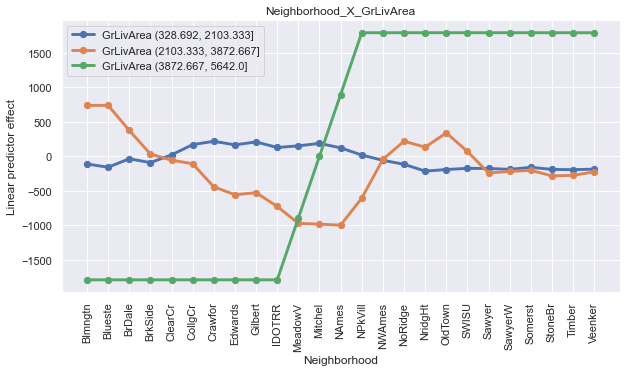

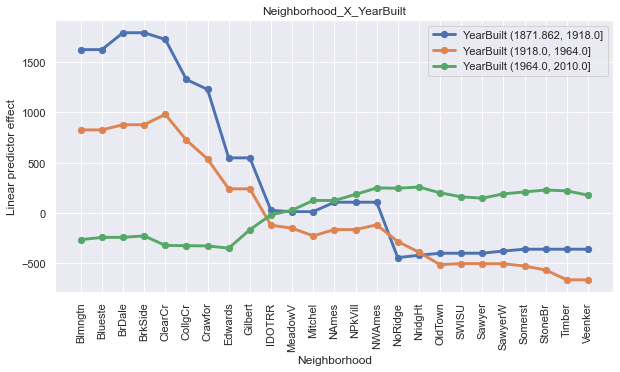

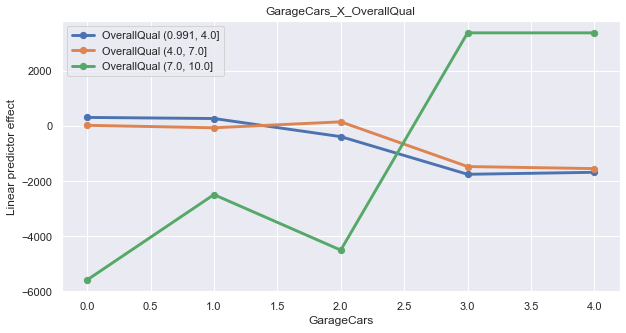

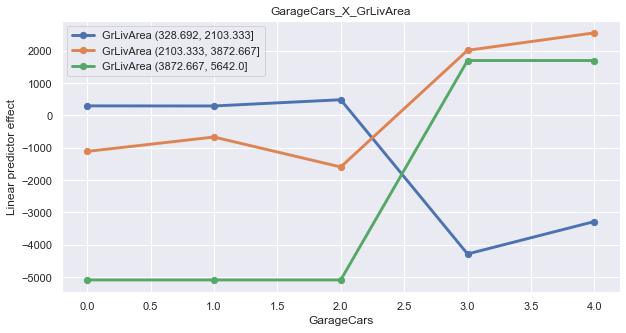

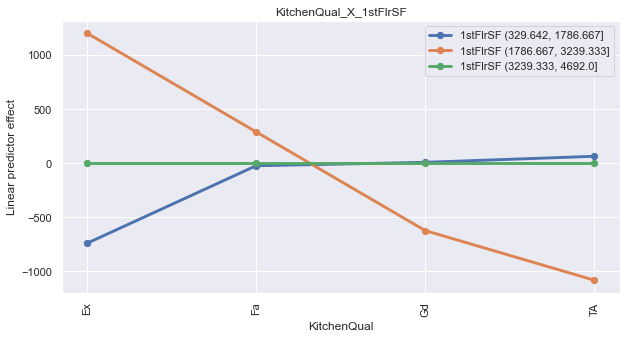

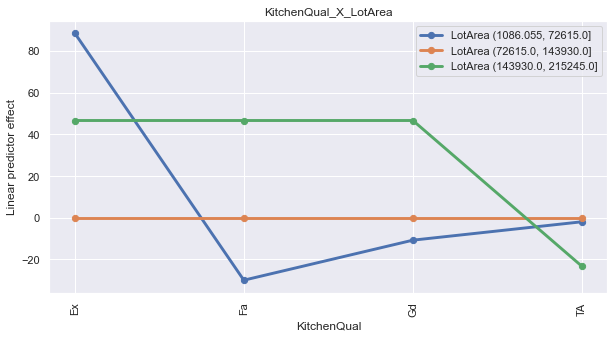

In [12]:
lgbm_viz.find_interactions([ "Neighborhood", "GarageCars","KitchenQual"], figsize=(10,5))

###  4.3. When to set `twofold_shap` to `True`?:

As mentioned before, if your dataset is too big, compting the SHAP values can be time consuming. 
To circumvent this problem, this package fits an additional model to predict the interaction values from the first model. If you know how SHAP interaction values work, you would know that the SHAP main effects for a particular feature are vertically dispersed and that is because of the interaction effects from other variables. So the secondary model's goal is to find the features that are causing the vertical dispersion for a specific variable being plotted. We do this by fitting the SHAP values the second time with the secondary model.

I use this approach since its runtime doesnt necessarily increase linearly with the dataset since, hence causing the runtime to be significantly smaller.
Note that the second model is only fit when you call the `find_interactions()` function. So everytime you call it,as many models are fit as there are variables passed in the function.


Now lets take a look at results when we set `twofold_shap=True`:

In [13]:
%%time
lgbm_twofold = LGBMVisualizer(params=params, data=df, target_column=target_column, weight_column=weight_column, n_trees=200,
                      twofold_shap=True, pc_data_for_interaction_detection=0.0)

CPU times: total: 9.31 s
Wall time: 739 ms


**TIP**: If you want to access the shap values directly, you can do so by accessing the `shap_data` attribute of LGBMVisualizer() as shown below:

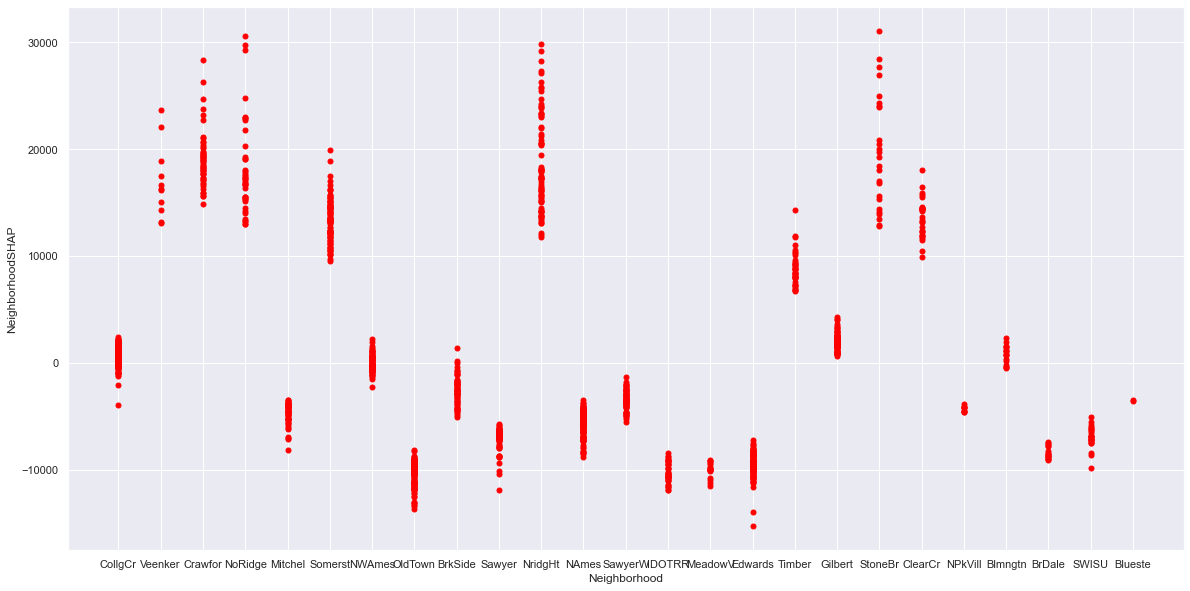

In [14]:
df["NeighborhoodSHAP"] = lgbm_twofold.shap_data["Neighborhood"]
_ = df.plot(kind="scatter", x="Neighborhood", y="NeighborhoodSHAP", s=25, c="red", figsize=(20,10),
            edgecolors="red")
df = df.drop("NeighborhoodSHAP", axis=1)

#### 4.3.1 Plotting 2-way interactions for a pair of variables:

Let us now look at a 2-way interaction between `("OverallQual", "GrLivArea")` same as we did before. Note that using the find_interaction() function with twofold_shap=True will take time a moment to run since it fits the secondary model to determine the  vertical dispersion in `OverallQual` & then plotting the interaction it has against `GrLivArea` .

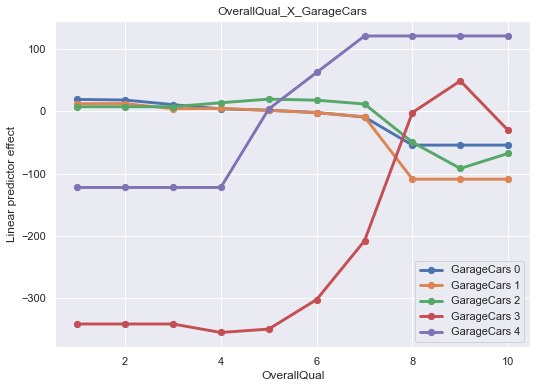

In [15]:
lgbm_twofold.find_interactions(("OverallQual", "GarageCars"), total_bins_for_num_cols=5)

You can see that the interaction trends are pretty similar with some changes between bins.

#### 4.3.2 Finding top N interactions for a particular variable:

Similarly, lets look at the top 5 interactions with `OverallQual`. Notice that the interaction results vary since the logic to find the most impactful interactions is different.


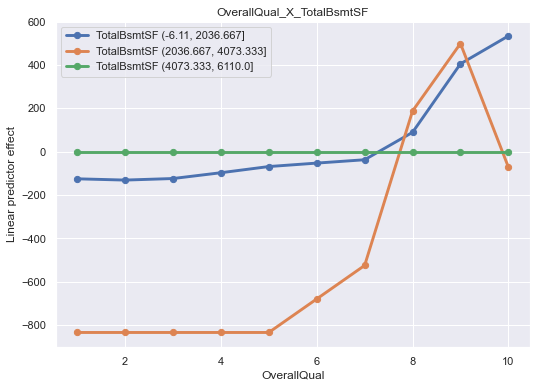

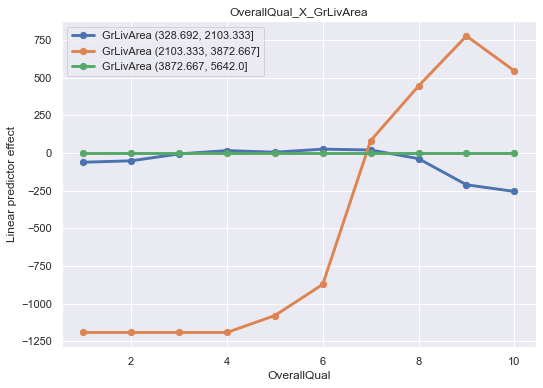

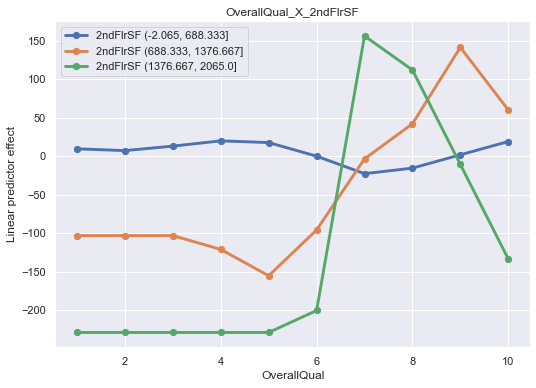

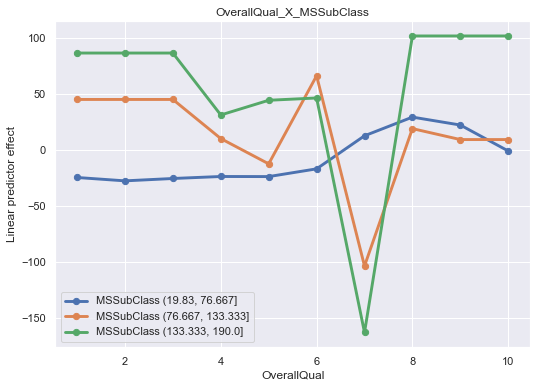

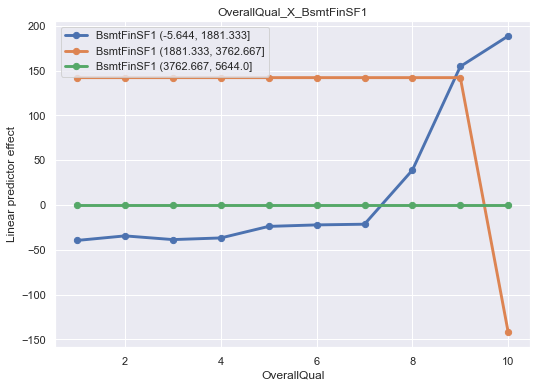

In [16]:
lgbm_twofold.find_interactions("OverallQual", total_interactions_per_var=5)

#### 4.3.3 Finding top N interactions for a list of variables:

Given a list of more than 2 variables, the `find_interactions()` function fits as many models & SHAP values for all these models are calculated since these models are variable specific.


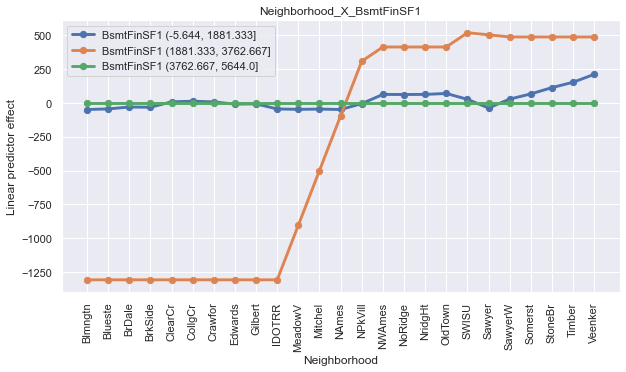

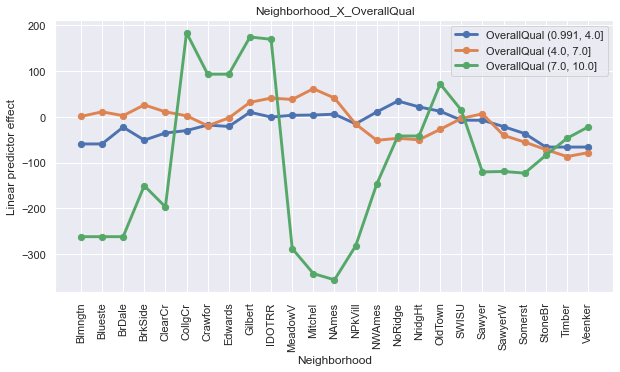

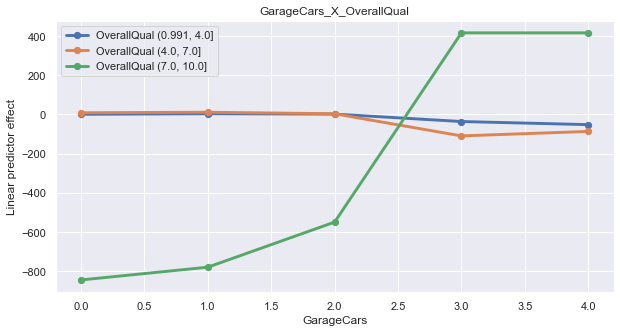

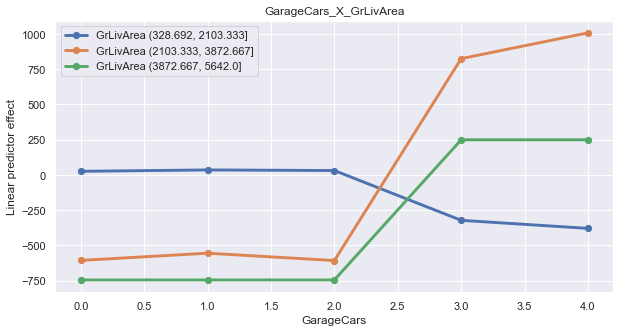

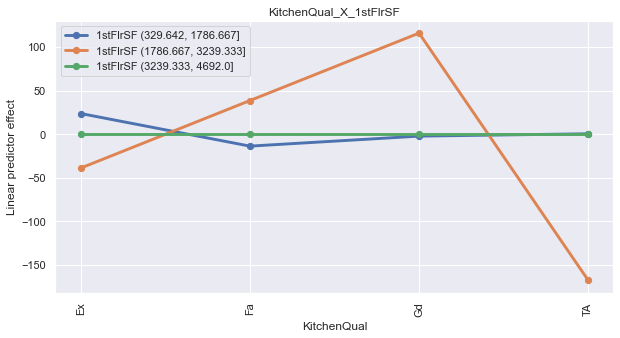

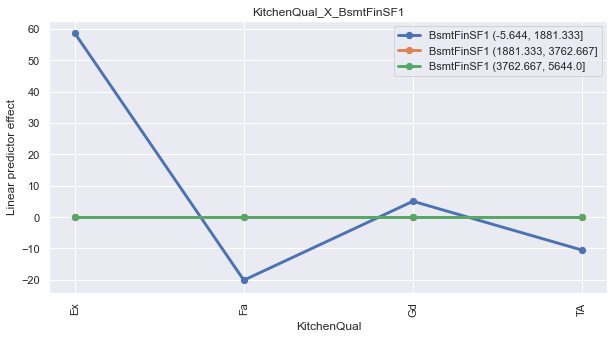

In [17]:
lgbm_twofold.find_interactions(["Neighborhood", "GarageCars","KitchenQual"], total_interactions_per_var=2, figsize=(10,5))

### 4.4 Plotting SHAP main effects:

If you want to just point the SHAP main effects(effects of the variable on the target variable) of the variable, you can just pass the variable name twice in a tuple.
Lets compare the main effects of `OverallQual` when `twofold_shap` is set to `True` and `False`

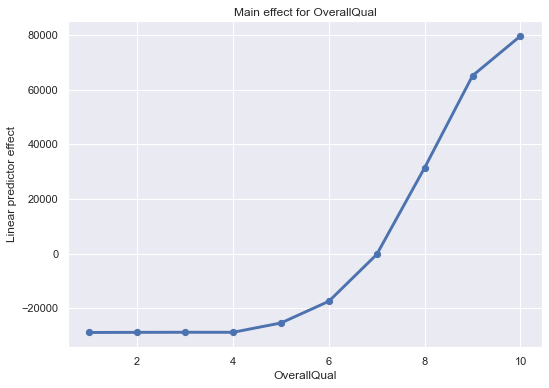

In [18]:
###When `twofold_shap` is set to `False`
lgbm_viz.find_interactions(("OverallQual", "OverallQual"))

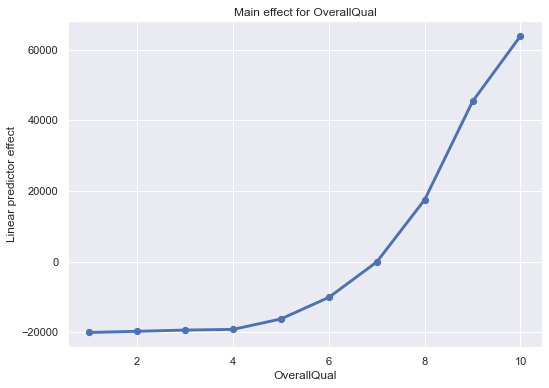

In [19]:
###When `twofold_shap` is set to `True`
lgbm_twofold.find_interactions(("OverallQual", "OverallQual"))

Once again very similar results. 
Just as when you plot the main effects using the original SHAP package, the y-axis here represents the average effects of the variable on x-axis on the prediction of your target variable. 

The scale of the y-axis depends on the type of objective function you have. In this example, the objective function we use is `rmse`. If you used a `poisson` objective then the y-axis would be on a log scale. This package works with any objective function that SHAP supports.

### 4.5 SHAP Scatterplots:

The lineplots shown above are the averages of SHAP values for each individual data point.
To get a more birds-eye view of the SHAP value distribution you can use the `scatter_plot` argument set to `True` as shown below:

**TIP** : Ideally you should place the variable with lesser levels in the second position as those are easier to bin

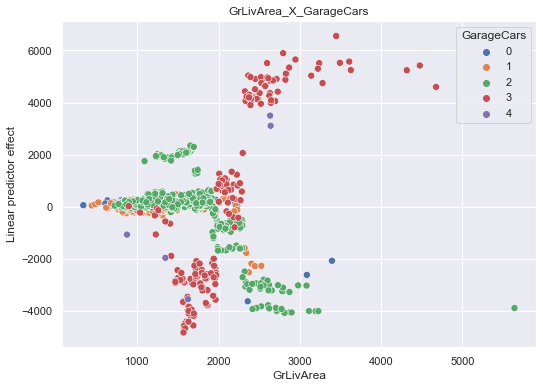

In [20]:
lgbm_viz.find_interactions(("GrLivArea", "GarageCars" ), scatter_plot=True, total_bins_for_num_cols=5)

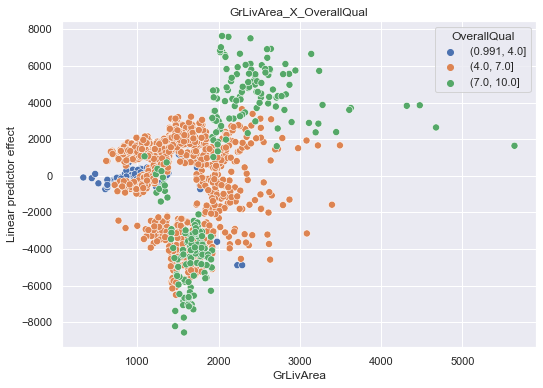

In [21]:
lgbm_viz.find_interactions("GrLivArea", scatter_plot=True, total_interactions_per_var=1)

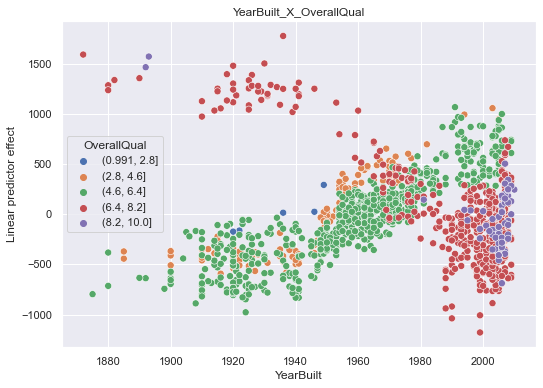

In [22]:
lgbm_viz.find_interactions("YearBuilt", scatter_plot=True, total_interactions_per_var=1,total_bins_for_num_cols=5)

### 4.6 Customising your plot:


#### 4.6.1 Using `custom_bin_for_interactionplot` argument for variable specific custom bins:

The `find_interactions()` function created bins of equal width for numerical variables, but whats plotted on the y-axis can have a skewed distribution that is difficult to interpret.
In such cases, the user can specify a custom bin arrary that represents how the y-axis variable is binned using the `custom_bin_for_interactionplot` argument.

Lets have a look below on how we can define a customised & also an uneven bin for `OverallQual` variable :

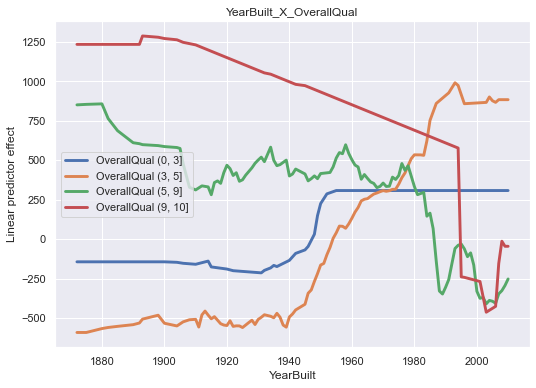

In [64]:
customBin = [0, 3, 5, 9, 10]

lgbm_viz.find_interactions(("YearBuilt","OverallQual"), scatter_plot=False, total_interactions_per_var=1,
                           total_bins_for_num_cols=4 ,
                           custom_bin_for_interactionplot=customBin)


#### 4.6.2 Using `moving_avg_window_size` & `moving_avg_min_periods` arguments to smooth out the volatile lineplots:

* As mentioned before, lineplots are created by taking moving averages of interaction values in the y-axis. The default window size is 5. You can increase or decrease this using the `moving_avg_window_size` argument to make the lineplots more or less smooth
* Secondly, while calculating the moving averages, if the neighboring points are mostly missing, then the resulting value is NaN. You can use the `moving_avg_min_periods` argument to determine how many non-missing values you need to calculate the average. Currently this defaults to 1, so you would need atleast 1 non-missing values within your window size to give out a non-NaN value.

Lets look at the interaction between `"TotalBsmtSF" &"OverallQual"` with default as well as higher `moving_avg_window_size` & `moving_avg_min_periods` values:

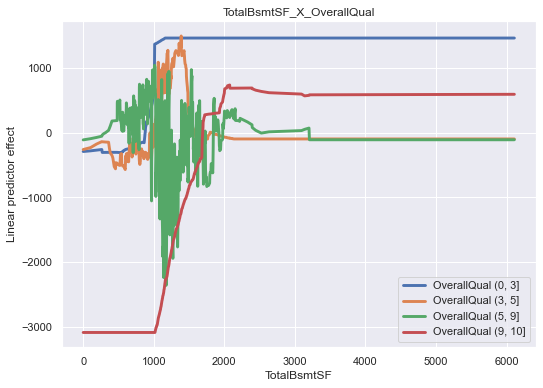

In [65]:
customBin = [0, 3, 5, 9, 10]
lgbm_viz.find_interactions(("TotalBsmtSF","OverallQual"), scatter_plot=False, 
                           total_interactions_per_var=1,
                           total_bins_for_num_cols=5 ,
                           custom_bin_for_interactionplot=customBin)


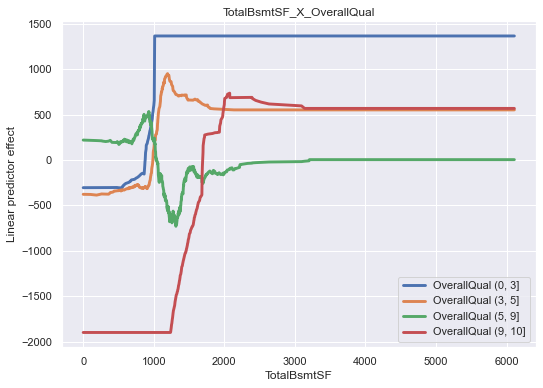

In [68]:
lgbm_viz.find_interactions(("TotalBsmtSF","OverallQual"), scatter_plot=False, 
                           total_interactions_per_var=1,
                           total_bins_for_num_cols=5 ,
                           custom_bin_for_interactionplot=customBin,
                          moving_avg_window_size=100,
                          moving_avg_min_periods=50)


As you can see above, the lines are much smoother & easier for the user to understand.

### 4.7 Limitations of LGBMVisualizer:

* The most common & easy to fix limitation of `lgbmisualizer` package is that the top interactions that are recommended often are between highly correlated features. This limitation exists whether you use `twofold_shap=True` or `False`. This can be easily fixed if you dont use highly correlated variables in your model which luckily happens to be standard practice while modelling.

* Observational weights are currently not considered when when moving average of interaction values are computed to plot lineplots.

* Currently there is no option to bin the x-axis variables , so the user are supposed to bin it themselves before using this package


### 4.8 Things not covered in this tutorial:
* You can use this package for multi-classification models but note that you have to specify the `main_class_for_multiclassification` argument with the class name which is the focus of your study. Else, the package will use the majority class as the main class. SHAP package doesnt truly support multi-class models, hence a workaround for that is to use the 1vsAll approach where you build separate models for each class & then compute interaction values separately. At the time of writing this, I dont know of any study that can somehow combine SHAP interactions values for multi-class models, hence this approach is all we've got. Luckily this package implements this approach for you without the user having to change their data themselves.